In [1]:
#import libraries
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# for Mac errors
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import numpy as np

In [2]:
# load data
cbsa = pd.read_csv("Market_Saturation_and_Utilization_CBSA_Dataset_Release_16_20231010.csv")
cbsa.head(5)

,reference_period,type_of_service,aggregation_level,cbsa,cbsatitle,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,number_of_users,...,average_number_of_providers_per_cbsa_dual_color,average_number_of_providers_per_cbsa_description,number_of_dual_eligible_users_dual_color,number_of_dual_eligible_users_description,percentage_of_dual_eligible_users_out_of_total_users_dual_color,percentage_of_dual_eligible_users_out_of_total_users_description,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color_description,total_payment_dual_color,total_payment_description
0,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),NATION + TERRITORIES,--ALL--,--ALL--,"37,359,009","9,078",424.34,10.31%,"3,852,199",...,,,,,,,,,,
1,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),CBSA,10100,"Aberdeen, SD","7,526",3,231,9.21%,693,...,BLUE 1,Lowest 25% (Less than 5.00 Providers),BLUE 2,Second Lowest 25% (166 - 349 Dual Eligible Users),BLUE 2,Second Lowest 25% (21.67% - 26.95% of Total Us...,BLUE 3,Third Lowest 25% (17.06% - 19.32% of Total FFS...,BLUE 2,"Second Lowest 25% ($525,929.51 - $1,042,852.56 )"
2,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),CBSA,10140,"Aberdeen, WA","17,349",18,110.44,11.46%,"1,988",...,BLUE 4,Top 25% Excl. Extreme Values (16.00 - 32.49 Pr...,BLUE 3,Third Lowest 25% (350 - 845 Dual Eligible Users),BLUE 4,Top 25% Excl. Extreme Values (33.58% - 51.44% ...,BLUE 4,Top 25% Excl. Extreme Values (19.33% - 27.78% ...,BLUE 3,"Third Lowest 25% ($1,042,852.57 - $2,686,138.28 )"
3,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),CBSA,10180,"Abilene, TX","25,198",11,271.09,11.83%,"2,982",...,BLUE 3,Third Lowest 25% (9.00 - 15.99 Providers),BLUE 4,"Top 25% Excl. Extreme Values (846 - 1,864 Dual...",BLUE 3,Third Lowest 25% (26.96% - 33.57% of Total Users),BLUE 4,Top 25% Excl. Extreme Values (19.33% - 27.78% ...,BLUE 3,"Third Lowest 25% ($1,042,852.57 - $2,686,138.28 )"
4,2015-01-01 to 2015-12-31,Ambulance (Emergency & Non-Emergency),CBSA,10220,"Ada, OK","7,570",5,104.8,6.92%,524,...,BLUE 2,Second Lowest 25% (5.00 - 8.99 Providers),BLUE 2,Second Lowest 25% (166 - 349 Dual Eligible Users),BLUE 4,Top 25% Excl. Extreme Values (33.58% - 51.44% ...,BLUE 1,Lowest 25% (Less than 13.69% of Total FFS Bene...,BLUE 1,"Lowest 25% (Less than $525,929.51 )"


In [3]:
cbsa.shape

(144881, 35)

In [4]:
# remove percent and dollar signs
cbsa = cbsa.replace('%', '', regex=True)
cbsa = cbsa.replace('\$', '', regex=True)

# remove aggregate
cbsa = cbsa[cbsa['cbsa'] != '--ALL--']

In [5]:
print(cbsa.columns)

Index(['reference_period', 'type_of_service', 'aggregation_level', 'cbsa',
       'cbsatitle', 'number_of_fee_for_service_beneficiaries',
       'number_of_providers', 'average_number_of_users_per_provider',
       'percentage_of_users_out_of_ffs_beneficiaries', 'number_of_users',
       'average_number_of_providers_per_cbsa', 'number_of_dual_eligible_users',
       'percentage_of_dual_eligible_users_out_of_total_users',
       'percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries',
       'total_payment', 'number_of_fee_for_service_beneficiaries_dual_color',
       'number_of_fee_for_service_beneficiaries_description',
       'number_of_providers_dual_color', 'number_of_providers_description',
       'average_number_of_users_per_provider_dual_color',
       'average_number_of_users_per_provider_description',
       'percentage_of_users_out_of_ffs_beneficiaries_dual_color',
       'percentage_of_users_out_of_ffs_beneficiaries_description',
       'number_of_users_du

<table style="border:1px solid black;">
  <tr>
    <th width="200px" style="background-color: lightgrey; border:1px solid black;">Quantitative (interval)</th>
    <th width="200px" style="background-color: lightgrey; border:1px solid black;">Quantitative (ratio)   </th>
  </tr>
  <tr>
    <td style="background-color: lightblue; vertical-align: top; border:1px solid black;">start_date, end_date</td>
    <td style="background-color: lightblue; vertical-align: top; border:1px solid black;">number_of_fee_for_service_beneficiaries,
number_of_providers,
average_number_of_users_per_provider,
percentage_of_users_out_of_ffs_beneficiaries,
number_of_users,
average_number_of_providers_per_cbsa,
number_of_dual_eligible_users,
percentage_of_dual_eligible_users_out_of_total_users,
percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries,
total_payment
</td>
  </tr>
</table>

<table>
  <tr>
    <th width="200px" style="background-color: lightgrey; border:1px solid black;">Qualitative (nominal)</th>
    <th width="200px" style="background-color: lightgrey; border:1px solid black;">Qualitative (ordinal)</th>
  </tr>
  <tr>
    <td style="background-color: lightblue; vertical-align: top; border:1px solid black;">type_of_service,
cbsa,
cbsatitle
    <td style="background-color: lightblue; vertical-align: top; border:1px solid black;">
aggregation_level,
number_of_fee_for_service_beneficiaries_dual_color,
number_of_fee_for_service_beneficiaries_description,
number_of_providers_dual_color,
number_of_providers_description,
average_number_of_users_per_provider_dual_color,
average_number_of_users_per_provider_description,
percentage_of_users_out_of_ffs_beneficiaries_dual_color,
percentage_of_users_out_of_ffs_beneficiaries_description,
number_of_users_dual_color,
number_of_users_description,
average_number_of_providers_per_cbsa_dual_color,
average_number_of_providers_per_cbsa_description,
number_of_dual_eligible_users_dual_color,
number_of_dual_eligible_users_description,
percentage_of_dual_eligible_users_out_of_total_users_dual_color,
percentage_of_dual_eligible_users_out_of_total_users_description,
percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color,
percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color_description,
total_payment_dual_color,
total_payment_description
    </td>
  </tr>
</table>

In [6]:
cbsa[['start_date', 'end_date']] = cbsa['reference_period'].str.split(' to ', expand=True)
cbsa.insert(0, 'end_date', cbsa.pop('end_date'))
cbsa.insert(0, 'start_date', cbsa.pop('start_date'))
cbsa.drop(["reference_period"], axis = 1, inplace= True)

In [7]:
# convert date columns to datetime
cbsa[['start_date', 'end_date']] = cbsa[['start_date', 'end_date']].apply(pd.to_datetime)

**Identifying and Converting Attributes**

In [8]:
convert_numerical = [
    'number_of_fee_for_service_beneficiaries',
    'number_of_providers',
    'number_of_users',
    'number_of_dual_eligible_users',
    'average_number_of_users_per_provider',
    'percentage_of_users_out_of_ffs_beneficiaries',
    'average_number_of_providers_per_cbsa',
    'percentage_of_dual_eligible_users_out_of_total_users',
    'percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries',
    'total_payment'
]

for column in convert_numerical:
    cbsa[column] = cbsa[column].str.replace(' ', '').str.replace(',', '')
    cbsa[column] = pd.to_numeric(cbsa[column], downcast=None)

In [9]:
# identify and convert to categorical
convert_to_category = [
    'type_of_service',
    'cbsa',
    'cbsatitle',
    'aggregation_level',
    'number_of_fee_for_service_beneficiaries_dual_color',
    'number_of_fee_for_service_beneficiaries_description',
    'number_of_providers_dual_color',
    'number_of_providers_description',
    'average_number_of_users_per_provider_dual_color',
    'average_number_of_users_per_provider_description',
    'percentage_of_users_out_of_ffs_beneficiaries_dual_color',
    'percentage_of_users_out_of_ffs_beneficiaries_description',
    'number_of_users_dual_color',
    'number_of_users_description',
    'average_number_of_providers_per_cbsa_dual_color',
    'average_number_of_providers_per_cbsa_description',
    'number_of_dual_eligible_users_dual_color',
    'number_of_dual_eligible_users_description',
    'percentage_of_dual_eligible_users_out_of_total_users_dual_color',
    'percentage_of_dual_eligible_users_out_of_total_users_description',
    'percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color',
    'percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color_description',
    'total_payment_dual_color',
    'total_payment_description'
]
cbsa[convert_to_category] = cbsa[convert_to_category].astype('category')


In [10]:
print(cbsa.dtypes)

start_date                                                                                         datetime64[ns]
end_date                                                                                           datetime64[ns]
type_of_service                                                                                          category
aggregation_level                                                                                        category
cbsa                                                                                                     category
cbsatitle                                                                                                category
number_of_fee_for_service_beneficiaries                                                                     int64
number_of_providers                                                                                         int64
average_number_of_users_per_provider                                                    

In [11]:
cbsa.describe()

,start_date,end_date,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,number_of_users,average_number_of_providers_per_cbsa,number_of_dual_eligible_users,percentage_of_dual_eligible_users_out_of_total_users,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries,total_payment
count,144715,144715,1.447150e+05,144715.000000,141350.000000,144715.000000,1.447150e+05,144715.000000,132026.000000,132026.000000,132026.000000,1.447150e+05
mean,2018-07-14 18:35:44.999481600,2019-07-14 00:33:48.129772288,3.871407e+04,49.618056,116.399974,12.945911,5.099865e+03,49.618056,1038.777741,23.847503,15.186126,1.151631e+07
min,2015-01-01 00:00:00,2015-12-31 00:00:00,4.070000e+02,0.000000,2.310000,0.010000,1.100000e+01,0.000000,11.000000,0.470000,0.010000,6.046100e+02
25%,2017-01-01 00:00:00,2017-12-31 00:00:00,6.239500e+03,4.000000,42.122500,2.570000,2.400000e+02,4.000000,66.000000,13.570000,3.940000,2.194421e+05
50%,2019-01-01 00:00:00,2019-12-31 00:00:00,1.201100e+04,10.000000,66.750000,5.920000,8.060000e+02,10.000000,195.000000,20.830000,9.650000,9.211999e+05
75%,2021-01-01 00:00:00,2021-12-31 00:00:00,2.691200e+04,28.000000,132.097500,15.540000,2.842500e+03,28.000000,601.000000,31.150000,20.160000,4.471906e+06
max,2022-01-01 00:00:00,2022-12-31 00:00:00,2.523066e+06,16732.000000,2581.130000,74.450000,1.421406e+06,16732.000000,231507.000000,100.000000,79.170000,6.625352e+09
std,NaN,NaN,1.174877e+05,275.389520,138.871776,15.940015,2.597981e+04,275.389520,5380.292491,13.984618,15.282265,8.141815e+07


## Data Preparation

Clean and prepare data for data analysis


    - change misleading field values
    - remap categorical as numerical
    - standardize numeric variables
    - identify outliers

In [12]:
cbsa.isnull().sum()

start_date                                                                                             0
end_date                                                                                               0
type_of_service                                                                                        0
aggregation_level                                                                                      0
cbsa                                                                                                   0
cbsatitle                                                                                              0
number_of_fee_for_service_beneficiaries                                                                0
number_of_providers                                                                                    0
average_number_of_users_per_provider                                                                3365
percentage_of_users_out_of_ffs_beneficiaries           

The CMS Integrated Data Repository excluded CBSAs that were incomplete from the source dataset, specifically dual eligibility metrics.

In [13]:
# cbsa.to_csv('cbsa.csv', index=False)

In [14]:
cbsa_2015 = cbsa[cbsa['start_date'].dt.year == 2015]
cbsa_2016 = cbsa[cbsa['start_date'].dt.year == 2016]
cbsa_2017 = cbsa[cbsa['start_date'].dt.year == 2017]
cbsa_2018 = cbsa[cbsa['start_date'].dt.year == 2018]
cbsa_2019 = cbsa[cbsa['start_date'].dt.year == 2019]
cbsa_2020 = cbsa[cbsa['start_date'].dt.year == 2020]
cbsa_2021 = cbsa[cbsa['start_date'].dt.year == 2021]
cbsa_2022 = cbsa[cbsa['start_date'].dt.year == 2022]

In [15]:
cbsa10100 = cbsa[cbsa['cbsa'] == "10100"]
# pd.set_option('display.max_rows', None)
cbsa10100[['start_date','number_of_dual_eligible_users']]

,start_date,number_of_dual_eligible_users
1,2015-01-01,174.0
937,2015-01-01,166.0
1870,2015-01-01,30.0
2753,2015-01-01,NaN
3427,2015-01-01,80.0
...,...,...
140308,2022-01-01,357.0
141246,2022-01-01,58.0
142151,2022-01-01,185.0
143086,2022-01-01,73.0


In [16]:
cbsa['cbsa'].nunique()

961

In [17]:
cbsa43980 = cbsa[cbsa['cbsa'] == "43980"]
# pd.set_option('display.max_rows', None)
cbsa43980[['start_date','type_of_service','number_of_dual_eligible_users']]

,start_date,type_of_service,number_of_dual_eligible_users
806,2015-01-01,Ambulance (Emergency & Non-Emergency),NaN
1741,2015-01-01,Ambulance (Emergency),NaN
2631,2015-01-01,Ambulance (Non-Emergency),NaN
4214,2015-01-01,Chiropractic Services,81.0
5157,2015-01-01,Clinical Laboratory (Billing Independently),90.0
...,...,...,...
141114,2022-01-01,Preventive Health Services,146.0
142020,2022-01-01,Psychotherapy,38.0
142955,2022-01-01,Pulmonology,62.0
143852,2022-01-01,Skilled Nursing Facility,23.0


In [18]:
# create a subset of cbsa with complete dual data
dual_subset = ['start_date','type_of_service','cbsa','number_of_dual_eligible_users']

cbsa_dual = cbsa[dual_subset].sort_values('start_date').dropna().drop_duplicates(
    subset=['type_of_service', 'cbsa'], keep='last')

In [19]:
# fill missing values with the most recent available data
match_cols = ['cbsa','type_of_service']
cbsa = cbsa.set_index(match_cols).fillna(cbsa_dual.set_index(match_cols)).reset_index()

In [20]:
cbsa.isnull().sum()

cbsa                                                                                                   0
type_of_service                                                                                        0
start_date                                                                                             0
end_date                                                                                               0
aggregation_level                                                                                      0
cbsatitle                                                                                              0
number_of_fee_for_service_beneficiaries                                                                0
number_of_providers                                                                                    0
average_number_of_users_per_provider                                                                3365
percentage_of_users_out_of_ffs_beneficiaries           

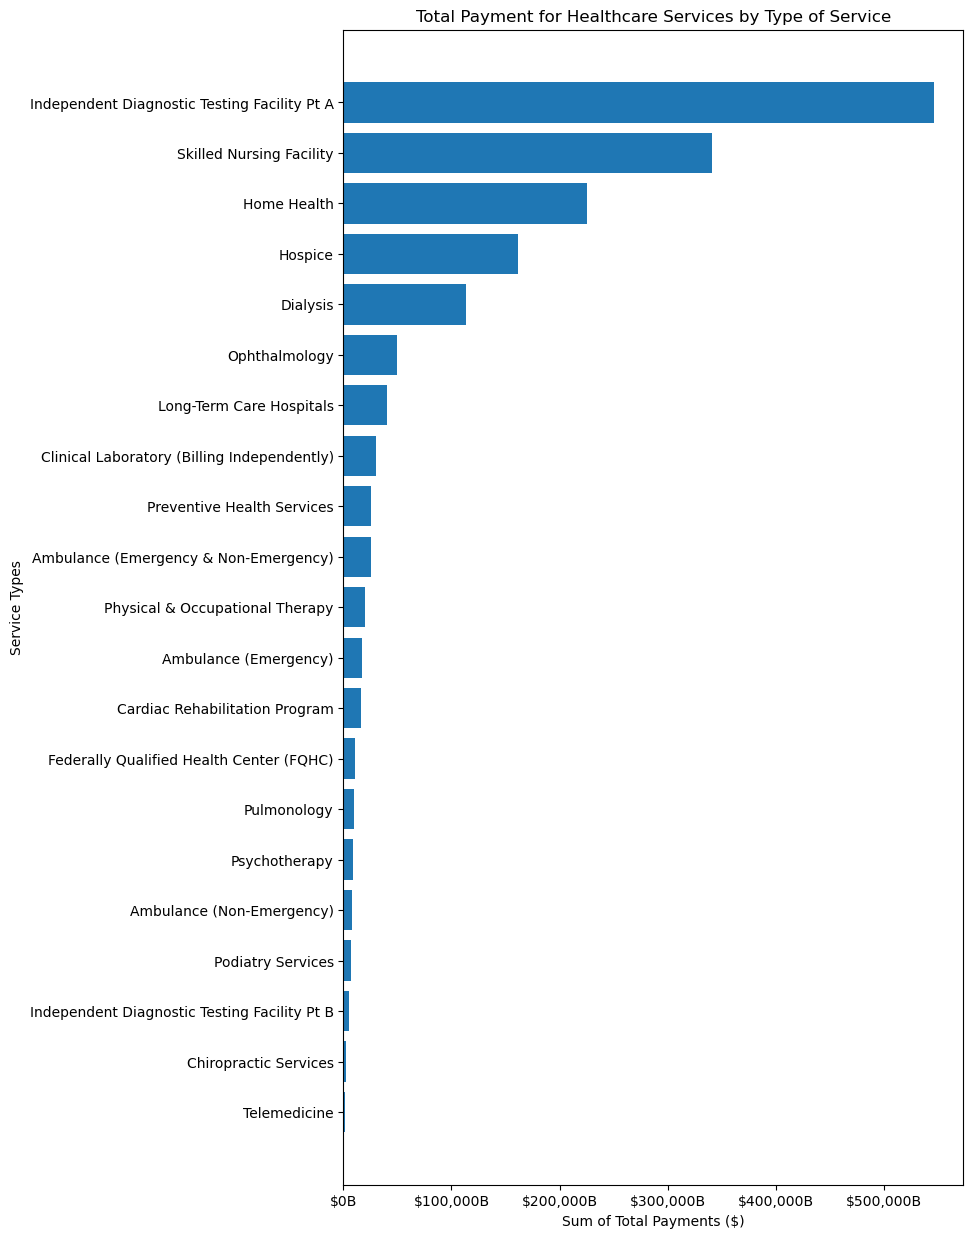

In [28]:
# visualization to see the total payment across different service types
service_payment = cbsa.groupby('type_of_service', as_index=False)['total_payment'].sum()
service_payment.sort_values(by = ['total_payment'], inplace=True)
fig = plt.figure(figsize = (8,15))
plt.barh(service_payment['type_of_service'], service_payment['total_payment'])
plt.title("Total Payment for Healthcare Services by Type of Service")
plt.xlabel("Sum of Total Payments ($)")
plt.ylabel("Service Types")

# format x-axis for readability
def format_dollars(x, pos):
    return '${:,.0f}B'.format(x/1e6)
    
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_dollars))
plt.show()

In [22]:
cbsa['type_of_service'].nunique()

21

In [30]:
# total billion dollars
print(cbsa[cbsa['type_of_service'] == 
"Ambulance (Emergency & Non-Emergency)"]['total_payment'].sum())

25289499327.34


In [31]:
# total billion dollars
print(cbsa[cbsa['type_of_service'] == 
"Independent Diagnostic Testing Facility Pt A"]['total_payment'].sum())

546470718664.02997
